In [4]:
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import nibabel as nib
from tqdm.notebook import tqdm
from torchvision import transforms, datasets, models
from torch.optim import lr_scheduler
from torchsummary import summary
from train import train_model, train_accuracy, train_loss, val_accuracy, val_loss
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
torch.cuda.is_available()

True

In [31]:
import cv2
import numpy as np
import os
import sys
import pandas as pd
from random import shuffle
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import lr_scheduler
import torchvision
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms, datasets, models
from PIL import Image
import nibabel as nib
import time
import copy
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    
def create_paths(datapath):
    #     Create paths to all nested images
    imagepaths = []
    for root, dirs, files in os.walk(datapath, topdown=False):
        for name in files:
            imagepaths.append(os.path.join(root, name))
    return imagepaths

def get_label(imagepath, csvpath):
    #     Get the diagnosis label for path
    table = pd.read_csv(csvpath)
    idpath = imagepath.split('/')[13]
    img_id = idpath[idpath.find('_I') + 2:-4]
    group = table.loc[table['Image Data ID'] == int(
        img_id)]["Group"].reset_index(drop=True)[0]
    group_to_label = {'CN': 0, 'MCI': 2, 'AD': 1}
    label = group_to_label[group]
    return label

class ADNI(Dataset):
    def __init__(self, datapath, csvpath, labels = [0, 1, 2], transform=None):
        """
        Args:
            datapath (string): Directory with all the images.
            csvpath (string): Path to CSV
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        all_imagepaths = create_paths(datapath)[:-1]
        self.csvpath = csvpath
        self.imagepaths = [path for path in tqdm(all_imagepaths) if get_label(path, csvpath) in labels] 
        self.transform = transform

    def __len__(self):
        #         Returns the length of the dataset
        return len(self.imagepaths)

    def __getitem__(self, idx):
        #         Returns a tuple of the image and its group/label
        imgsize = 64

        if torch.is_tensor(idx):
            idx = idx.tolist()
        imagepath = self.imagepaths[idx]
        label = get_label(imagepath, csvpath)
    

        imgdata = nib.load(imagepath).get_fdata()
        #         temporary, for only one slice
        imgdata = torch.from_numpy(cv2.resize(imgdata[imgdata.shape[0]//2, :, :], (imgsize, imgsize)))

    
        imgdata = torch.stack([imgdata, imgdata, imgdata],0) 
        imgdata = imgdata.reshape(3, imgsize, imgsize)
        
        if self.transform:
            imgdata = self.transform(imgdata)
        
        sample = (imgdata, torch.tensor(label))
        
        return sample
    
    
datapath = r"/media/swang/Windows/Users/swang/Downloads/ADNI1_Complete_1Yr_1.5T"
csvpath = r"/media/swang/Windows/Users/swang/Downloads/ADNI1_Complete_1Yr_1.5T_7_08_2020.csv"
dataset = ADNI(datapath, csvpath, labels = [0,1])
# transform = transforms.Normalize(mean=199.8274, std=220.4913))

lengths = [
    int(len(dataset) * 0.8),
    int(len(dataset) * 0.1),
    int(len(dataset) * 0.1) + 1
]


trainset, valset, testset = random_split(dataset, lengths)
image_datasets = {'train': trainset, 'val': valset, 'test': testset}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=4)
              for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']} 


In [32]:
model = models.resnet50(pretrained=True).to(device) 
model.fc = nn.Linear(model.fc.in_features, 2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer_ft = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [33]:
from torchsummary import summary
summary(model, (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           9,408
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]           4,096
       BatchNorm2d-6           [-1, 64, 16, 16]             128
              ReLU-7           [-1, 64, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          36,864
       BatchNorm2d-9           [-1, 64, 16, 16]             128
             ReLU-10           [-1, 64, 16, 16]               0
           Conv2d-11          [-1, 256, 16, 16]          16,384
      BatchNorm2d-12          [-1, 256, 16, 16]             512
           Conv2d-13          [-1, 256, 16, 16]          16,384
      BatchNorm2d-14          [-1, 256,

In [34]:
#!/usr/bin/env python
# coding: utf-8

import torch
import torch.nn as nn
import torch.nn.functional as F
import time
import copy
from tqdm.notebook import tqdm
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# for plotting
train_loss = []
train_accuracy = []
val_loss = []
val_accuracy = []

    
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 100)


        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval() 

            running_loss = 0.0
            running_corrects = 0


            for inputs, labels in tqdm(dataloaders[phase], total = dataset_sizes[phase]//32+1):
                inputs, labels = inputs.to(device, dtype=torch.float), labels.to(device)
            
                optimizer.zero_grad()


                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)


                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            if phase == 'train':
                train_loss.append(epoch_loss)
                train_accuracy.append(epoch_acc)
                
            if phase == 'val':
                val_loss.append(epoch_loss)
                val_accuracy.append(epoch_acc)
                
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))


            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())


    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model

In [35]:
# Three channel Resnet50 w/ normalization
model = train_model(model, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------------------------------------------------------------------------------------------------



train Loss: 0.6883 Acc: 0.5837



val Loss: 0.6732 Acc: 0.5763
Epoch 1/24
----------------------------------------------------------------------------------------------------



train Loss: 0.5115 Acc: 0.7585



val Loss: 0.6751 Acc: 0.6780
Epoch 2/24
----------------------------------------------------------------------------------------------------



train Loss: 0.3349 Acc: 0.8464



val Loss: 0.5646 Acc: 0.7881
Epoch 3/24
----------------------------------------------------------------------------------------------------



train Loss: 0.2038 Acc: 0.9216



val Loss: 0.6747 Acc: 0.7542
Epoch 4/24
----------------------------------------------------------------------------------------------------



train Loss: 0.1335 Acc: 0.9587



val Loss: 0.5211 Acc: 0.8136
Epoch 5/24
----------------------------------------------------------------------------------------------------



train Loss: 0.0826 Acc: 0.9682



val Loss: 0.7520 Acc: 0.7458
Epoch 6/24
----------------------------------------------------------------------------------------------------



train Loss: 0.0547 Acc: 0.9862



val Loss: 0.6557 Acc: 0.8136
Epoch 7/24
----------------------------------------------------------------------------------------------------



train Loss: 0.0371 Acc: 0.9894



val Loss: 0.5730 Acc: 0.8475
Epoch 8/24
----------------------------------------------------------------------------------------------------



train Loss: 0.0245 Acc: 0.9958



val Loss: 0.6019 Acc: 0.8220
Epoch 9/24
----------------------------------------------------------------------------------------------------



train Loss: 0.0272 Acc: 0.9936



val Loss: 0.5494 Acc: 0.8559
Epoch 10/24
----------------------------------------------------------------------------------------------------



train Loss: 0.0238 Acc: 0.9947



val Loss: 0.5725 Acc: 0.8136
Epoch 11/24
----------------------------------------------------------------------------------------------------



train Loss: 0.0143 Acc: 0.9989



val Loss: 0.5284 Acc: 0.8136
Epoch 12/24
----------------------------------------------------------------------------------------------------



train Loss: 0.0170 Acc: 0.9968



val Loss: 0.5757 Acc: 0.8136
Epoch 13/24
----------------------------------------------------------------------------------------------------



train Loss: 0.0134 Acc: 0.9989



val Loss: 0.6199 Acc: 0.7797
Epoch 14/24
----------------------------------------------------------------------------------------------------



train Loss: 0.0143 Acc: 0.9989



val Loss: 0.5376 Acc: 0.8136
Epoch 15/24
----------------------------------------------------------------------------------------------------



train Loss: 0.0140 Acc: 0.9979



val Loss: 0.6175 Acc: 0.7966
Epoch 16/24
----------------------------------------------------------------------------------------------------



train Loss: 0.0188 Acc: 0.9979



val Loss: 0.5748 Acc: 0.8136
Epoch 17/24
----------------------------------------------------------------------------------------------------



train Loss: 0.0123 Acc: 0.9979



val Loss: 0.6096 Acc: 0.7966
Epoch 18/24
----------------------------------------------------------------------------------------------------



train Loss: 0.0144 Acc: 0.9989



val Loss: 0.5545 Acc: 0.8136
Epoch 19/24
----------------------------------------------------------------------------------------------------



train Loss: 0.0196 Acc: 0.9968



val Loss: 0.5608 Acc: 0.8220
Epoch 20/24
----------------------------------------------------------------------------------------------------



train Loss: 0.0114 Acc: 0.9989



val Loss: 0.5675 Acc: 0.8136
Epoch 21/24
----------------------------------------------------------------------------------------------------



train Loss: 0.0223 Acc: 0.9958



val Loss: 0.5724 Acc: 0.8051
Epoch 22/24
----------------------------------------------------------------------------------------------------



train Loss: 0.0136 Acc: 0.9979



val Loss: 0.6104 Acc: 0.8051
Epoch 23/24
----------------------------------------------------------------------------------------------------



train Loss: 0.0090 Acc: 1.0000



val Loss: 0.5876 Acc: 0.8051
Epoch 24/24
----------------------------------------------------------------------------------------------------



train Loss: 0.0136 Acc: 0.9968



val Loss: 0.6186 Acc: 0.8051
Training complete in 18m 2s
Best val Acc: 0.855932


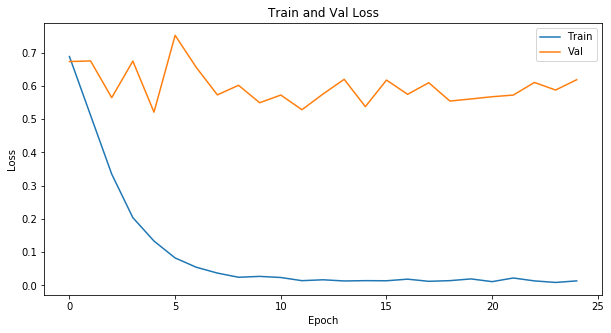

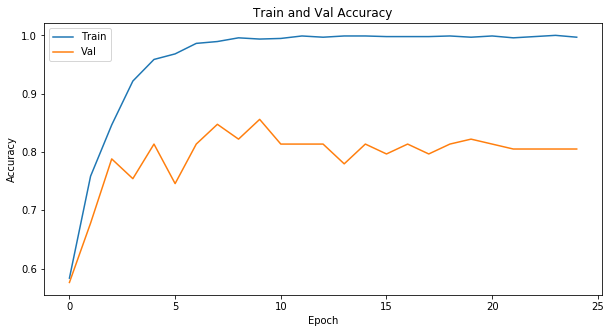

In [37]:
plt.figure(figsize=(10,5))
plt.title("Train and Val Loss")
plt.plot(train_loss,label="Train")
plt.plot(val_loss,label="Val")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()
plt.figure(figsize=(10,5))
plt.title("Train and Val Accuracy")
plt.plot(train_accuracy,label="Train")
plt.plot(val_accuracy,label="Val")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [44]:
running_loss = 0.0
running_corrects = 0
for inputs, labels in tqdm(dataloaders['test'], total = dataset_sizes['test']//32+1):
    inputs, labels = inputs.to(device, dtype=torch.float), labels.to(device)


    with torch.no_grad():
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)


    running_loss += loss.item() * inputs.size(0)
    running_corrects += torch.sum(preds == labels.data)
    
print(f"Test Loss: {running_loss / dataset_sizes['test']}\nTest Accuracy: {running_corrects.double() / dataset_sizes['test']}")



Test Loss: 0.4451789360086457
Test Accuracy: 0.8319327731092437
